# MNIST handwritten digits classification with CNNs

Author: Bethany Lusch, adapting codes from Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the MNIST problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## MNIST data set

Again we'll load the MNIST handwritten digits data set.  If you haven't downloaded it already, it could take a while.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (60000, 28, 28), i.e. it consists of 60000 images of size 28x28 pixels. 

`y_train` is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample.

## Convolutional model

Let's use a small model that includes convolutional layers

In [3]:
class MNISTClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network. The fit function handles looping over the batches. We'll see a more verbose approach below that allows more performance tuning.

In [4]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = MNISTClassifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    x_train_reshaped = numpy.expand_dims(x_train, -1)
    history = cnn_model.fit(x_train_reshaped, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [5]:
# This took 55 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 52s 875us/sample - loss: 0.4196 - accuracy: 0.8720
Epoch 2/3
60000/60000 [==============================] - 54s 899us/sample - loss: 0.1164 - accuracy: 0.9651
Epoch 3/3
60000/60000 [==============================] - 54s 904us/sample - loss: 0.0816 - accuracy: 0.9755


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

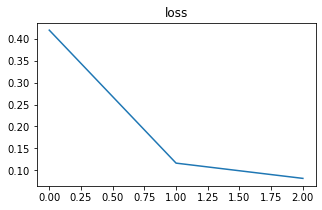

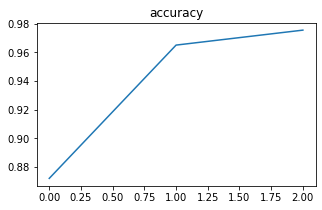

In [6]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [7]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test_reshaped, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

10000/1 - 5s - loss: 0.0232 - accuracy: 0.9868
accuracy: 98.68%
CPU times: user 8.4 s, sys: 43.4 s, total: 51.8 s
Wall time: 4.62 s


We can also again check the confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test_reshaped)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[ 975    0    1    0    0    0    1    1    2    0]
 [   0 1128    3    0    0    1    2    0    1    0]
 [   0    0 1028    0    0    0    0    3    1    0]
 [   0    0    6 1001    0    1    0    1    1    0]
 [   0    0    1    0  967    0    2    0    2   10]
 [   2    0    1   10    0  872    3    0    2    2]
 [   6    2    0    0    2    1  945    0    2    0]
 [   1    1   12    1    0    0    0 1009    1    3]
 [   4    1    5    1    3    0    1    3  952    4]
 [   3    3    0    2    3    4    0    1    2  991]]

Classification accuracy for each class:

0: 0.9949
1: 0.9938
2: 0.9961
3: 0.9911
4: 0.9847
5: 0.9776
6: 0.9864
7: 0.9815
8: 0.9774
9: 0.9822


### More verbose training

This approach explicitly handles the looping over data. It will be helpful this afternoon for diving in and optimizing

It takes about 45 seconds per epoch on my laptop (18% less than the above code).

In [9]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [10]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [22]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(60000/batch_size)
        dataset.shuffle(60000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 28, 28, 1])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [23]:
def get_dataset():

    # Read in the mnist data so we have it loaded globally:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(numpy.float32)
    x_test  = x_test.astype(numpy.float32)

    x_train /= 255.
    x_test  /= 255.

    y_train = y_train.astype(numpy.int32)
    y_test  = y_test.astype(numpy.int32)

    return x_train, x_test, y_train, y_test

In [32]:
x_train, x_test, y_train, y_test = get_dataset()

In [33]:
def fetch_batch(_batch_size):
    
    indexes = numpy.random.choice(a=x_train.shape[0], size=[_batch_size,])

    images = x_train[indexes].reshape(_batch_size, 28, 28, 1)
    labels = y_train[indexes].reshape(_batch_size, 1)

    return images, labels

In [25]:
def train_loop2(batch_size, n_training_epochs, model, opt):

    for i_epoch in range(n_training_epochs):
        start = time.time()

        epoch_steps = int(60000/batch_size)

        for i_batch in range(epoch_steps):

            with tf.GradientTape() as tape:
                batch_data, y_true = fetch_batch(batch_size)
                y_pred = model(batch_data)
                loss = compute_loss(y_true, y_pred)

            trainable_vars = model.trainable_variables

            # Apply the update to the network (one at a time):
            grads = tape.gradient(loss, trainable_vars)

            opt.apply_gradients(zip(grads, trainable_vars))
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [26]:
def train_network(_batch_size, _n_training_epochs, _lr):

    mnist_model = MNISTClassifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, mnist_model, opt)

In [27]:
def train_network2(_batch_size, _n_training_epochs, _lr):

    mnist_model = MNISTClassifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop2(_batch_size, _n_training_epochs, mnist_model, opt)

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(60000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 45.4 seconds for epoch #0
beginning epoch 1
took 48.0 seconds for epoch #1
beginning epoch 2
took 46.8 seconds for epoch #2


In [34]:
batch_size = 512
epochs = 3
lr = .01
train_network2(batch_size, epochs, lr)

took 105.8 seconds for epoch #0
took 109.6 seconds for epoch #1
took 104.7 seconds for epoch #2


In [ ]:
# 136 seconds per epoch if get_dataset inside fetch batch 